# Long-Short Strategy, Part 2: Trading signals with LightGBM and CatBoost

In this section, we'll start designing, implementing, and evaluating a trading strategy for US equities driven by daily return forecasts produced by gradient boosting models.

As in the previous examples, we'll lay out a framework and build a specific example that you can adapt to run your own experiments. There are numerous aspects that you can vary, from the asset class and investment universe to more granular aspects like the features, holding period, or trading rules. See, for example, the **Alpha Factor Library** in the [Appendix](../24_alpha_factor_library) for numerous additional features.

We'll keep the trading strategy simple and only use a single ML signal; a real-life application will likely use multiple signals from different sources, such as complementary ML models trained on different datasets or with different lookahead or lookback periods. It would also use sophisticated risk management, from simple stop-loss to value-at-risk analysis.

**Six notebooks** cover our workflow sequence:

1. [preparing_the_model_data](04_preparing_the_model_data.ipyny): we engineer a few simple features from the Quandl Wiki data 
2. `trading_signals_with_lightgbm_and_catboost`  (this noteboook): we tune hyperparameters for LightGBM and CatBoost to select a model, using 2015/16 as our validation period. 
3. [evaluate_trading_signals](06_evaluate_trading_signals.ipynb): we compare the cross-validation performance using various metrics to select the best model. 
4. [model_interpretation](07_model_interpretation.ipynb): we take a closer look at the drivers behind the best model's predictions.
5. [making_out_of_sample_predictions](08_making_out_of_sample_predictions.ipynb): we generate predictions for our out-of-sample test period 2017.
6. [backtesting_with_zipline](09_backtesting_with_zipline.ipynb): evaluate the historical performance of a long-short strategy based on our predictive signals using Zipline.

We'll subset the dataset created in the preceding notebook through the end of 2016 to cross-validate several model configurations for various lookback and lookahead windows, as well as different roll-forward periods and hyperparameters. 

Our approach to model selection will be similar to the one we used in the previous chapter and uses the custom `MultipleTimeSeriesCV` introduced in [Chapter 7, Linear Models – From Risk Factors to Return Forecasts](../07_linear_models).

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import sys, os
from time import time
from tqdm import tqdm

from collections import defaultdict
from itertools import product

import numpy as np
import pandas as pd

import lightgbm as lgb
from catboost import Pool, CatBoostRegressor

from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

from alphalens.tears import (create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens.utils import get_clean_factor_and_forward_returns

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV, format_time

In [4]:
sns.set_style('whitegrid')

In [5]:
YEAR = 252
idx = pd.IndexSlice

## Get Data

We select the train and validation sets, and identify labels and features:

In [6]:
data = (pd.read_hdf('data.h5', 'model_data')
            .sort_index()
            .loc[idx[:, :'2017'], :]) # train & validation period
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1110557 entries, ('000020', Timestamp('2010-04-05 00:00:00')) to ('128820', Timestamp('2017-12-28 00:00:00'))
Data columns (total 34 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   dollar_vol       1110557 non-null  float64
 1   dollar_vol_rank  1110557 non-null  float64
 2   rsi              1110557 non-null  float64
 3   bb_high          1110557 non-null  float64
 4   bb_low           1110557 non-null  float64
 5   NATR             1110557 non-null  float64
 6   ATR              1110557 non-null  float64
 7   PPO              1110557 non-null  float64
 8   MACD             1110557 non-null  float64
 9   sector           1110557 non-null  int32  
 10  r01              1110557 non-null  float64
 11  r05              1110557 non-null  float64
 12  r10              1110557 non-null  float64
 13  r21              1110557 non-null  float64
 14  r42              1110557 non-null 

In [7]:
labels = sorted(data.filter(like='_fwd').columns)
features = data.columns.difference(labels).tolist() # features are columns not containing '_fwd'

In [8]:
data

dollar_vol  dollar_vol_rank        rsi   bb_high  \
symbol date                                                            
000020 2010-04-05  1014.005040            243.0  32.814698  0.091034   
       2010-04-06   501.243600            248.0  42.846934  0.071166   
       2010-04-07   546.932100            256.0  47.100287  0.059957   
       2010-04-08   478.094720            258.0  48.856942  0.049861   
       2010-04-09   440.564500            268.0  44.123185  0.057312   
...                        ...              ...        ...       ...   
128820 2017-12-21   290.727720            400.0  54.064530  0.048743   
       2017-12-22   172.874405            401.0  53.710598  0.048028   
       2017-12-26   281.401200            409.0  47.962284  0.059577   
       2017-12-27   220.453415            411.0  52.177251  0.029847   
       2017-12-28   381.716725            415.0  61.060746 -0.008966   

                     bb_low      NATR       ATR       PPO      MACD  sector  \
symbol date                                                                   
000020 2010-04-05  0.001407  2.173222 -0.854541 -1.252542 -0.557743      30   
       2010-04-06  0.026926  2.161861 -0.832321 -1.565939 -0.549990      30   
       2010-04-07  0.039134  2.137699 -0.831836 -1.734365 -0.501830      30   
       2010-04-08  0.042282  2.057448 -0.871685 -1.786313 -0.443558      30   
       2010-04-09  0.027901  2.046515 -0.895254 -1.842072 -0.441020      30   
...                     ...       ...       ...       ...       ...     ...   
128820 2017-12-21  0.045690  4.301318 -0.793255 -1.675968  0.369005      87   
       2017-12-22  0.044759  4.154569 -0.796892 -1.614101  0.369026      87   
       2017-12-26  0.020469  4.216758 -0.797728 -1.599051  0.363626      87   
       2017-12-27  0.029177  4.021522 -0.800583 -1.509005  0.363177      87   
       2017-12-28  0.073277  3.969183 -0.797460 -1.204955  0.373009      87   

                   ...  r10q_sector  r21q_sector  r42q_sector  r63q_sector  \
symbol date        ...                                                       
000020 2010-04-05  ...          1.0          2.0          2.0          0.0   
       2010-04-06  ...          2.0          2.0          3.0          0.0   
       2010-04-07  ...          3.0          2.0          2.0          0.0   
       2010-04-08  ...          3.0          2.0          3.0          0.0   
       2010-04-09  ...          3.0          1.0          2.0          0.0   
...                ...          ...          ...          ...          ...   
128820 2017-12-21  ...          NaN          NaN          NaN          NaN   
       2017-12-22  ...          NaN          NaN          NaN          NaN   
       2017-12-26  ...          NaN          NaN          NaN          NaN   
       2017-12-27  ...          NaN          NaN          NaN          NaN   
       2017-12-28  ...          NaN          NaN          NaN          NaN   

                    r01_fwd   r05_fwd   r21_fwd  year  month  weekday  
symbol date                                                            
000020 2010-04-05  0.023973  0.027397  0.011986  2010      4        0  
       2010-04-06  0.011706  0.000000 -0.031773  2010      4        1  
       2010-04-07  0.004959 -0.009917 -0.077686  2010      4        2  
       2010-04-08 -0.014803 -0.004934 -0.062500  2010      4        3  
       2010-04-09  0.001669  0.003339 -0.053422  2010      4        4  
...                     ...       ...       ...   ...    ...      ...  
128820 2017-12-21 -0.001355       NaN       NaN  2017     12        3  
       2017-12-22 -0.023066       NaN       NaN  2017     12        4  
       2017-12-26  0.018056       NaN       NaN  2017     12        1  
       2017-12-27  0.046385       NaN       NaN  2017     12        2  
       2017-12-28       NaN       NaN       NaN  2017     12        3  

[1110557 rows x 34 columns]

## Model Selection: Lookback, lookahead and roll-forward periods

In [9]:
tickers = data.index.get_level_values('symbol').unique()

We may want to predict 1, 5 or 21-day returns:

In [10]:
lookaheads = [1, 5, 21]
# lookaheads = [1]

In [11]:
categoricals = ['year', 'month', 'sector', 'weekday']

We select 4.5 and one years as the length of our training periods; test periods are one and three months long. Since we are using two years (2015/16) for validation, a one-month test period implies 24 folds.

In [12]:
train_lengths = [int(4.5 * 252), 252]
test_lengths = [63, 21]

In [13]:
test_params = list(product(lookaheads, train_lengths, test_lengths))

In [14]:
results_path = Path('results', 'kr_stocks')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Baseline: Linear Regression

We always want to know how much our (gradient boosting) is improving over a simpler baseline (if at all..).

In [27]:
lr = LinearRegression()

In [30]:
lr_metrics = []

# iterate over our three CV configuration parameters
for lookahead, train_length, test_length in tqdm(test_params):
    label = f'r{lookahead:02}_fwd'
    df = pd.get_dummies(data.loc[:, features + [label]].dropna(), 
                        columns=categoricals, 
                        drop_first=True)
    X, y = df.drop(label, axis=1), df[label]

    n_splits = int(2 * YEAR / test_length)
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              test_period_length=test_length,
                              lookahead=lookahead,
                              train_period_length=train_length)

    ic, preds = [], []
    for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        preds.append(y_test.to_frame('y_true').assign(y_pred=y_pred))
        ic.append(spearmanr(y_test, y_pred)[0])
    preds = pd.concat(preds)
    lr_metrics.append([lookahead, 
                       train_length, 
                       test_length,
                       np.mean(ic),
                       spearmanr(preds.y_true, preds.y_pred)[0]
                      ])

columns = ['lookahead', 'train_length', 'test_length', 'ic_by_day', 'ic']
lr_metrics = pd.DataFrame(lr_metrics, columns=columns)

  0%|                                                                                           | 0/12 [00:00<?, ?it/s]

[    715     716     717 ... 1035557 1035558 1035559]
[    652     653     654 ... 1035494 1035495 1035496]
[    589     590     591 ... 1035431 1035432 1035433]
[    526     527     528 ... 1035368 1035369 1035370]
[    463     464     465 ... 1035305 1035306 1035307]
[    400     401     402 ... 1035242 1035243 1035244]
[    337     338     339 ... 1035179 1035180 1035181]
[    274     275     276 ... 1035116 1035117 1035118]


  8%|██████▉                                                                            | 1/12 [00:33<06:03, 33.06s/it]

[    757     758     759 ... 1035599 1035600 1035601]
[    736     737     738 ... 1035578 1035579 1035580]
[    715     716     717 ... 1035557 1035558 1035559]
[    694     695     696 ... 1035536 1035537 1035538]
[    673     674     675 ... 1035515 1035516 1035517]
[    652     653     654 ... 1035494 1035495 1035496]
[    631     632     633 ... 1035473 1035474 1035475]
[    610     611     612 ... 1035452 1035453 1035454]
[    589     590     591 ... 1035431 1035432 1035433]
[    568     569     570 ... 1035410 1035411 1035412]
[    547     548     549 ... 1035389 1035390 1035391]
[    526     527     528 ... 1035368 1035369 1035370]
[    505     506     507 ... 1035347 1035348 1035349]
[    484     485     486 ... 1035326 1035327 1035328]
[    463     464     465 ... 1035305 1035306 1035307]
[    442     443     444 ... 1035284 1035285 1035286]
[    421     422     423 ... 1035263 1035264 1035265]
[    400     401     402 ... 1035242 1035243 1035244]
[    379     380     381 ...

 17%|█████████████▊                                                                     | 2/12 [02:02<11:01, 66.11s/it]

[   1597    1598    1599 ... 1035557 1035558 1035559]
[   1534    1535    1536 ... 1035494 1035495 1035496]
[   1471    1472    1473 ... 1035431 1035432 1035433]
[   1408    1409    1410 ... 1035368 1035369 1035370]
[   1345    1346    1347 ... 1035305 1035306 1035307]
[   1282    1283    1284 ... 1035242 1035243 1035244]
[   1219    1220    1221 ... 1035179 1035180 1035181]
[   1156    1157    1158 ... 1035116 1035117 1035118]


 25%|████████████████████▊                                                              | 3/12 [02:10<05:55, 39.49s/it]

[   1639    1640    1641 ... 1035599 1035600 1035601]
[   1618    1619    1620 ... 1035578 1035579 1035580]
[   1597    1598    1599 ... 1035557 1035558 1035559]
[   1576    1577    1578 ... 1035536 1035537 1035538]
[   1555    1556    1557 ... 1035515 1035516 1035517]
[   1534    1535    1536 ... 1035494 1035495 1035496]
[   1513    1514    1515 ... 1035473 1035474 1035475]
[   1492    1493    1494 ... 1035452 1035453 1035454]
[   1471    1472    1473 ... 1035431 1035432 1035433]
[   1450    1451    1452 ... 1035410 1035411 1035412]
[   1429    1430    1431 ... 1035389 1035390 1035391]
[   1408    1409    1410 ... 1035368 1035369 1035370]
[   1387    1388    1389 ... 1035347 1035348 1035349]
[   1366    1367    1368 ... 1035326 1035327 1035328]
[   1345    1346    1347 ... 1035305 1035306 1035307]
[   1324    1325    1326 ... 1035284 1035285 1035286]
[   1303    1304    1305 ... 1035263 1035264 1035265]
[   1282    1283    1284 ... 1035242 1035243 1035244]
[   1261    1262    1263 ...

 33%|███████████████████████████▋                                                       | 4/12 [02:28<04:09, 31.23s/it]

[    703     704     705 ... 1033377 1033378 1033379]
[    640     641     642 ... 1033314 1033315 1033316]
[    577     578     579 ... 1033251 1033252 1033253]
[    514     515     516 ... 1033188 1033189 1033190]
[    451     452     453 ... 1033125 1033126 1033127]
[    388     389     390 ... 1033062 1033063 1033064]
[    325     326     327 ... 1032999 1033000 1033001]
[    262     263     264 ... 1032936 1032937 1032938]


 42%|██████████████████████████████████▌                                                | 5/12 [03:00<03:41, 31.59s/it]

[    745     746     747 ... 1033419 1033420 1033421]
[    724     725     726 ... 1033398 1033399 1033400]
[    703     704     705 ... 1033377 1033378 1033379]
[    682     683     684 ... 1033356 1033357 1033358]
[    661     662     663 ... 1033335 1033336 1033337]
[    640     641     642 ... 1033314 1033315 1033316]
[    619     620     621 ... 1033293 1033294 1033295]
[    598     599     600 ... 1033272 1033273 1033274]
[    577     578     579 ... 1033251 1033252 1033253]
[    556     557     558 ... 1033230 1033231 1033232]
[    535     536     537 ... 1033209 1033210 1033211]
[    514     515     516 ... 1033188 1033189 1033190]
[    493     494     495 ... 1033167 1033168 1033169]
[    472     473     474 ... 1033146 1033147 1033148]
[    451     452     453 ... 1033125 1033126 1033127]
[    430     431     432 ... 1033104 1033105 1033106]
[    409     410     411 ... 1033083 1033084 1033085]
[    388     389     390 ... 1033062 1033063 1033064]
[    367     368     369 ...

 50%|█████████████████████████████████████████▌                                         | 6/12 [04:31<05:10, 51.72s/it]

[   1585    1586    1587 ... 1033377 1033378 1033379]
[   1522    1523    1524 ... 1033314 1033315 1033316]
[   1459    1460    1461 ... 1033251 1033252 1033253]
[   1396    1397    1398 ... 1033188 1033189 1033190]
[   1333    1334    1335 ... 1033125 1033126 1033127]
[   1270    1271    1272 ... 1033062 1033063 1033064]
[   1207    1208    1209 ... 1032999 1033000 1033001]
[   1144    1145    1146 ... 1032936 1032937 1032938]


 58%|████████████████████████████████████████████████▍                                  | 7/12 [04:39<03:06, 37.36s/it]

[   1627    1628    1629 ... 1033419 1033420 1033421]
[   1606    1607    1608 ... 1033398 1033399 1033400]
[   1585    1586    1587 ... 1033377 1033378 1033379]
[   1564    1565    1566 ... 1033356 1033357 1033358]
[   1543    1544    1545 ... 1033335 1033336 1033337]
[   1522    1523    1524 ... 1033314 1033315 1033316]
[   1501    1502    1503 ... 1033293 1033294 1033295]
[   1480    1481    1482 ... 1033272 1033273 1033274]
[   1459    1460    1461 ... 1033251 1033252 1033253]
[   1438    1439    1440 ... 1033230 1033231 1033232]
[   1417    1418    1419 ... 1033209 1033210 1033211]
[   1396    1397    1398 ... 1033188 1033189 1033190]
[   1375    1376    1377 ... 1033167 1033168 1033169]
[   1354    1355    1356 ... 1033146 1033147 1033148]
[   1333    1334    1335 ... 1033125 1033126 1033127]
[   1312    1313    1314 ... 1033104 1033105 1033106]
[   1291    1292    1293 ... 1033083 1033084 1033085]
[   1270    1271    1272 ... 1033062 1033063 1033064]
[   1249    1250    1251 ...

 67%|███████████████████████████████████████████████████████▎                           | 8/12 [04:57<02:05, 31.31s/it]

[    655     656     657 ... 1024645 1024646 1024647]
[    592     593     594 ... 1024582 1024583 1024584]
[    529     530     531 ... 1024519 1024520 1024521]
[    466     467     468 ... 1024456 1024457 1024458]
[    403     404     405 ... 1024393 1024394 1024395]
[    340     341     342 ... 1024330 1024331 1024332]
[    277     278     279 ... 1024267 1024268 1024269]
[    214     215     216 ... 1024204 1024205 1024206]


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [05:30<01:34, 31.58s/it]

[    697     698     699 ... 1024687 1024688 1024689]
[    676     677     678 ... 1024666 1024667 1024668]
[    655     656     657 ... 1024645 1024646 1024647]
[    634     635     636 ... 1024624 1024625 1024626]
[    613     614     615 ... 1024603 1024604 1024605]
[    592     593     594 ... 1024582 1024583 1024584]
[    571     572     573 ... 1024561 1024562 1024563]
[    550     551     552 ... 1024540 1024541 1024542]
[    529     530     531 ... 1024519 1024520 1024521]
[    508     509     510 ... 1024498 1024499 1024500]
[    487     488     489 ... 1024477 1024478 1024479]
[    466     467     468 ... 1024456 1024457 1024458]
[    445     446     447 ... 1024435 1024436 1024437]
[    424     425     426 ... 1024414 1024415 1024416]
[    403     404     405 ... 1024393 1024394 1024395]
[    382     383     384 ... 1024372 1024373 1024374]
[    361     362     363 ... 1024351 1024352 1024353]
[    340     341     342 ... 1024330 1024331 1024332]
[    319     320     321 ...

 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [07:04<01:41, 50.85s/it]

[   1537    1538    1539 ... 1024645 1024646 1024647]
[   1474    1475    1476 ... 1024582 1024583 1024584]
[   1411    1412    1413 ... 1024519 1024520 1024521]
[   1348    1349    1350 ... 1024456 1024457 1024458]
[   1285    1286    1287 ... 1024393 1024394 1024395]
[   1222    1223    1224 ... 1024330 1024331 1024332]
[   1159    1160    1161 ... 1024267 1024268 1024269]
[   1096    1097    1098 ... 1024204 1024205 1024206]


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [07:12<00:37, 37.77s/it]

[   1579    1580    1581 ... 1024687 1024688 1024689]
[   1558    1559    1560 ... 1024666 1024667 1024668]
[   1537    1538    1539 ... 1024645 1024646 1024647]
[   1516    1517    1518 ... 1024624 1024625 1024626]
[   1495    1496    1497 ... 1024603 1024604 1024605]
[   1474    1475    1476 ... 1024582 1024583 1024584]
[   1453    1454    1455 ... 1024561 1024562 1024563]
[   1432    1433    1434 ... 1024540 1024541 1024542]
[   1411    1412    1413 ... 1024519 1024520 1024521]
[   1390    1391    1392 ... 1024498 1024499 1024500]
[   1369    1370    1371 ... 1024477 1024478 1024479]
[   1348    1349    1350 ... 1024456 1024457 1024458]
[   1327    1328    1329 ... 1024435 1024436 1024437]
[   1306    1307    1308 ... 1024414 1024415 1024416]
[   1285    1286    1287 ... 1024393 1024394 1024395]
[   1264    1265    1266 ... 1024372 1024373 1024374]
[   1243    1244    1245 ... 1024351 1024352 1024353]
[   1222    1223    1224 ... 1024330 1024331 1024332]
[   1201    1202    1203 ...

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [07:31<00:00, 37.66s/it]


### Information Coefficient - Distribution by Lookahead

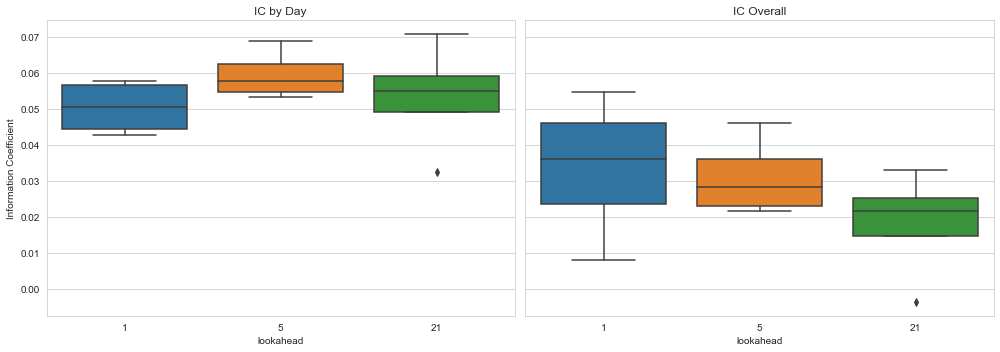

In [31]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5), sharey=True)

# plot average of daily IC values
sns.boxplot(x='lookahead', y='ic_by_day',data=lr_metrics, ax=axes[0])
axes[0].set_title('IC by Day')

# plot IC across all predictions
sns.boxplot(x='lookahead', y='ic',data=lr_metrics, ax=axes[1])
axes[1].set_title('IC Overall')
axes[0].set_ylabel('Information Coefficient')
axes[1].set_ylabel('')
fig.tight_layout()

### Best Train/Test Period Lengths

For one- and five-day return forecasts, shorter train- and test-length yield better results in terms of daily avg IC:

In [32]:
(lr_metrics.groupby('lookahead', group_keys=False)
 .apply(lambda x: x.nlargest(3, 'ic_by_day')))

,lookahead,train_length,test_length,ic_by_day,ic
0,1,1134,63,0.057549,0.054526
1,1,1134,21,0.056295,0.043302
2,1,252,63,0.044716,0.028831
7,5,252,21,0.068885,0.021455
5,5,1134,21,0.060347,0.032623
4,5,1134,63,0.055092,0.045973
9,21,1134,21,0.070776,0.020801
11,21,252,21,0.055217,-0.003813
8,21,1134,63,0.054429,0.022415


In [33]:
lr_metrics.to_csv(results_path / 'lin_reg_metrics.csv', index=False)

## LightGBM Model Tuning

The notebook example iterates over many configurations, optionally using random samples to speed up model selection using a diverse subset. The goal is to identify the most impactful parameters without trying every possible combination.

In [34]:
def get_fi(model):
    """Return normalized feature importance as pd.Series"""
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

### Hyperparameter Options

The `base_params` are not affected by cross-validation:

In [35]:
base_params = dict(boosting='gbdt',
                   objective='regression',
                   verbose=-1)

We choose the following parameters and values to select our best model (see book chapter for detail):

In [36]:
# constraints on structure (depth) of each tree
max_depths = [2, 3, 5, 7]
num_leaves_opts = [2 ** i for i in max_depths]
min_data_in_leaf_opts = [250, 500, 1000]

# weight of each new tree in the ensemble
learning_rate_ops = [.01, .1, .3]

# random feature selection
feature_fraction_opts = [.3, .6, .95]

In [37]:
param_names = ['learning_rate', 'num_leaves',
               'feature_fraction', 'min_data_in_leaf']

In [38]:
cv_params = list(product(learning_rate_ops,
                         num_leaves_opts,
                         feature_fraction_opts,
                         min_data_in_leaf_opts))
n_params = len(cv_params)
print(f'# Parameters: {n_params}')

# Parameters: 108


### Train/Test Period Lengths

In [39]:
lookaheads = [1, 5, 21]
# lookaheads = [1]
label_dict = dict(zip(lookaheads, labels))

We only use test periods of 63 days length to save some model training and evaluation time.

In [40]:
train_lengths = [int(4.5 * 252), 252]
test_lengths = [63]

In [41]:
test_params = list(product(lookaheads, train_lengths, test_lengths))
n = len(test_params)
test_param_sample = np.random.choice(list(range(n)), size=int(n), replace=False)
test_params = [test_params[i] for i in test_param_sample]
print('Train configs:', len(test_params))

Train configs: 6


### Categorical Variables

We integer-encode categorical variables with values starting at zero, as expected by LightGBM (not necessary
as long as the category codes have values less than $2^{32}$, but avoids a warning)

In [42]:
categoricals = ['year', 'weekday', 'month']
for feature in categoricals:
    data[feature] = pd.factorize(data[feature], sort=True)[0]

### Custom Loss Function: Information Coefficient

In [43]:
def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True
    return 'ic', spearmanr(preds, train_data.get_label())[0], is_higher_better

### Run Cross-Validation

To explore the hyperparameter space, we specify values for key parameters that we would like to test in combination. The sklearn library supports `RandomizedSearchCV` to cross-validate a subset of parameter combinations that are sampled randomly from specified distributions. We will implement a custom version that allows us to monitor performance so we can abort the search process once we're satisfied with the result, rather than specifying a set number of iterations beforehand.

In [44]:
lgb_store = Path(results_path / 'tuning_lgb.h5')

In [45]:
labels = sorted(data.filter(like='fwd').columns)
features = data.columns.difference(labels).tolist()

In [46]:
label_dict = dict(zip(lookaheads, labels))

In [47]:
num_iterations = [10, 25, 50, 75] + list(range(100, 501, 50))
num_boost_round = num_iterations[-1]

In [48]:
metric_cols = (param_names + ['t', 'daily_ic_mean', 'daily_ic_mean_n',
                              'daily_ic_median', 'daily_ic_median_n'] +
               [str(n) for n in num_iterations])

We iterate over our six CV configurations and collect the resulting metrics:

In [49]:
for lookahead, train_length, test_length in test_params:
    # randomized grid search
    cvp = np.random.choice(list(range(n_params)),
                           size=int(n_params / 2),
                           replace=False)
    cv_params_ = [cv_params[i] for i in cvp]

    # set up cross-validation
    n_splits = int(2 * YEAR / test_length)
    print(f'Lookahead: {lookahead:2.0f} | '
          f'Train: {train_length:3.0f} | '
          f'Test: {test_length:2.0f} | '
          f'Params: {len(cv_params_):3.0f} | '
          f'Train configs: {len(test_params)}')

    # time-series cross-validation
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              lookahead=lookahead,
                              test_period_length=test_length,
                              train_period_length=train_length)

    label = label_dict[lookahead]
    outcome_data = data.loc[:, features + [label]].dropna()
    
    # binary dataset
    lgb_data = lgb.Dataset(data=outcome_data.drop(label, axis=1),
                           label=outcome_data[label],
                           categorical_feature=categoricals,
                           free_raw_data=False)
    T = 0
    predictions, metrics, feature_importance, daily_ic = [], [], [], []
    
    # iterate over (shuffled) hyperparameter combinations
    for p, param_vals in enumerate(cv_params_):
        key = f'{lookahead}/{train_length}/{test_length}/' + '/'.join([str(p) for p in param_vals])
        params = dict(zip(param_names, param_vals))
        params.update(base_params)

        start = time()
        cv_preds, nrounds = [], []
        ic_cv = defaultdict(list)
        
        # iterate over folds
        for i, (train_idx, test_idx) in enumerate(cv.split(X=outcome_data)):
            
            # select train subset
            lgb_train = lgb_data.subset(used_indices=train_idx.tolist(),
                                       params=params).construct()
            
            # train model for num_boost_round
            model = lgb.train(params=params,
                              train_set=lgb_train,
                              num_boost_round=num_boost_round,
                              verbose_eval=False)
            # log feature importance
            if i == 0:
                fi = get_fi(model).to_frame()
            else:
                fi[i] = get_fi(model)

            # capture predictions
            test_set = outcome_data.iloc[test_idx, :]
            X_test = test_set.loc[:, model.feature_name()]
            y_test = test_set.loc[:, label]
            y_pred = {str(n): model.predict(X_test, num_iteration=n) for n in num_iterations}
            
            # record predictions for each fold
            cv_preds.append(y_test.to_frame('y_test').assign(**y_pred).assign(i=i))
        
        # combine fold results
        cv_preds = pd.concat(cv_preds).assign(**params)
        predictions.append(cv_preds)
        
        # compute IC per day
        by_day = cv_preds.groupby(level='date')
        ic_by_day = pd.concat([by_day.apply(lambda x: spearmanr(x.y_test, x[str(n)])[0]).to_frame(n)
                               for n in num_iterations], axis=1)
        daily_ic_mean = ic_by_day.mean()
        daily_ic_mean_n = daily_ic_mean.idxmax()
        daily_ic_median = ic_by_day.median()
        daily_ic_median_n = daily_ic_median.idxmax()
        
        # compute IC across all predictions
        ic = [spearmanr(cv_preds.y_test, cv_preds[str(n)])[0] for n in num_iterations]
        t = time() - start
        T += t
        
        # collect metrics
        metrics = pd.Series(list(param_vals) +
                            [t, daily_ic_mean.max(), daily_ic_mean_n, daily_ic_median.max(), daily_ic_median_n] + ic,
                            index=metric_cols)
        msg = f'\t{p:3.0f} | {format_time(T)} ({t:3.0f}) | {params["learning_rate"]:5.2f} | '
        msg += f'{params["num_leaves"]:3.0f} | {params["feature_fraction"]:3.0%} | {params["min_data_in_leaf"]:4.0f} | '
        msg += f' {max(ic):6.2%} | {ic_by_day.mean().max(): 6.2%} | {daily_ic_mean_n: 4.0f} | {ic_by_day.median().max(): 6.2%} | {daily_ic_median_n: 4.0f}'
        print(msg)

        # persist results for given CV run and hyperparameter combination
        metrics.to_hdf(lgb_store, 'metrics/' + key)
        ic_by_day.assign(**params).to_hdf(lgb_store, 'daily_ic/' + key)
        fi.T.describe().T.assign(**params).to_hdf(lgb_store, 'fi/' + key)
        cv_preds.to_hdf(lgb_store, 'predictions/' + key)

Lookahead:  1 | Train: 1134 | Test: 63 | Params:  54 | Train configs: 6
	  0 | 00:00:42 ( 42) |  0.30 |   4 | 95% | 1000 |   7.38% |  6.93% |  200 |  7.35% |  200
	  1 | 00:01:19 ( 37) |  0.01 |   4 | 60% |  500 |   5.26% |  5.13% |  500 |  5.28% |  500
	  2 | 00:01:55 ( 36) |  0.10 |   4 | 60% |  500 |   7.91% |  7.21% |  500 |  7.49% |  500
	  3 | 00:03:23 ( 89) |  0.10 | 128 | 95% |  250 |   7.09% |  7.18% |  100 |  7.36% |  150
	  4 | 00:04:07 ( 43) |  0.01 |   8 | 30% |  500 |   6.40% |  5.88% |  500 |  5.79% |  500
	  5 | 00:04:46 ( 39) |  0.10 |   8 | 30% |  250 |   8.58% |  7.68% |  500 |  8.16% |  300
	  6 | 00:06:25 (100) |  0.10 | 128 | 95% |  500 |   7.20% |  7.04% |  100 |  6.97% |  300
	  7 | 00:07:33 ( 68) |  0.10 | 128 | 60% |  250 |   7.37% |  7.37% |   75 |  7.69% |   75
	  8 | 00:08:17 ( 44) |  0.10 |   8 | 30% | 1000 |   8.59% |  7.56% |  450 |  7.85% |  250
	  9 | 00:08:60 ( 43) |  0.01 |   8 | 30% | 1000 |   6.57% |  5.99% |  500 |  5.83% |  500
	 10 | 00:09:59 ( 

	 35 | 00:15:36 ( 47) |  0.10 | 128 | 95% |  250 |   4.72% |  4.87% |  100 |  5.03% |  100
	 36 | 00:15:53 ( 16) |  0.01 |   4 | 95% |  500 |   2.94% |  3.40% |  500 |  3.08% |  500
	 37 | 00:16:15 ( 23) |  0.10 |  32 | 30% |  500 |   5.37% |  5.51% |  200 |  5.08% |  200
	 38 | 00:16:31 ( 16) |  0.10 |   8 | 30% |  250 |   5.11% |  5.33% |  450 |  5.45% |  450
	 39 | 00:16:48 ( 16) |  0.30 |   8 | 60% |  250 |   4.56% |  4.63% |   75 |  4.71% |  200
	 40 | 00:17:29 ( 42) |  0.30 | 128 | 60% |  500 |   4.29% |  4.12% |   25 |  3.98% |   25
	 41 | 00:18:08 ( 38) |  0.10 | 128 | 60% |  250 |   4.85% |  5.06% |  100 |  4.93% |   50
	 42 | 00:18:24 ( 16) |  0.30 |   4 | 95% | 1000 |   4.20% |  4.51% |  400 |  4.58% |  500
	 43 | 00:18:40 ( 16) |  0.30 |   8 | 30% | 1000 |   5.22% |  4.84% |  200 |  5.01% |  300
	 44 | 00:19:03 ( 22) |  0.30 |  32 | 95% |  250 |   4.36% |  4.01% |   50 |  4.07% |   50
	 45 | 00:19:18 ( 15) |  0.10 |   4 | 30% | 1000 |   5.14% |  5.02% |  500 |  4.70% |  500

	 16 | 00:12:57 ( 43) |  0.10 |  32 | 60% |  500 |   9.22% |  5.48% |  150 |  4.85% |  150
	 17 | 00:13:28 ( 31) |  0.01 |   4 | 60% |  500 |   5.20% |  4.08% |  450 |  3.30% |   25
	 18 | 00:14:04 ( 35) |  0.01 |   8 | 30% |  500 |   5.49% |  3.84% |  500 |  3.34% |  500
	 19 | 00:14:37 ( 33) |  0.30 |   8 | 60% |  500 |   8.83% |  5.48% |  500 |  5.00% |  400
	 20 | 00:15:11 ( 34) |  0.30 |   8 | 60% | 1000 |   7.88% |  5.47% |  200 |  4.88% |  300
	 21 | 00:15:46 ( 35) |  0.01 |   8 | 30% |  250 |   5.45% |  3.83% |  500 |  3.16% |  500
	 22 | 00:16:24 ( 37) |  0.30 |   8 | 95% | 1000 |   9.47% |  5.85% |  500 |  5.67% |  500
	 23 | 00:16:58 ( 34) |  0.30 |   4 | 95% | 1000 |   7.21% |  5.23% |  500 |  4.83% |  500
	 24 | 00:17:29 ( 31) |  0.30 |   4 | 30% |  250 |   6.93% |  5.95% |  400 |  5.30% |  400
	 25 | 00:18:03 ( 34) |  0.30 |   8 | 95% |  500 |  10.84% |  5.70% |  400 |  5.21% |  500
	 26 | 00:18:36 ( 33) |  0.30 |   8 | 30% |  500 |   8.25% |  5.92% |  350 |  5.32% |  450

	 52 | 00:40:03 ( 34) |  0.10 |   4 | 95% | 1000 |   7.85% |  8.19% |  450 |  7.75% |   10
	 53 | 00:40:37 ( 34) |  0.30 |   8 | 30% | 1000 |   3.59% |  7.91% |  300 |  7.72% |  450
Lookahead:  5 | Train: 252 | Test: 63 | Params:  54 | Train configs: 6
	  0 | 00:00:16 ( 16) |  0.10 |   8 | 60% | 1000 |   5.19% |  3.64% |  300 |  2.79% |   50
	  1 | 00:00:29 ( 13) |  0.30 |   4 | 30% | 1000 |   4.98% |  4.32% |   50 |  3.67% |   50
	  2 | 00:00:45 ( 15) |  0.30 |   8 | 60% | 1000 |   5.16% |  3.16% |  100 |  2.39% |  150
	  3 | 00:01:20 ( 35) |  0.30 | 128 | 30% |  250 |   4.48% |  2.55% |   50 |  2.13% |  200
	  4 | 00:01:43 ( 23) |  0.01 |  32 | 30% | 1000 |   4.53% |  4.17% |   75 |  3.77% |  100
	  5 | 00:01:59 ( 16) |  0.30 |   8 | 95% | 1000 |   5.35% |  3.96% |   50 |  2.74% |  100
	  6 | 00:02:21 ( 22) |  0.10 |  32 | 60% | 1000 |   5.28% |  3.42% |   75 |  2.64% |  450
	  7 | 00:02:53 ( 32) |  0.30 | 128 | 60% |  250 |   4.96% |  3.01% |   25 |  2.56% |  150
	  8 | 00:03:26 ( 3

## CatBoost Model Tuning

We repeat a similar process for CatBoost - see book and CatBoost [docs](https://catboost.ai/docs/concepts/about.html) for detail.

### Hyperparameter Options

In [15]:
param_names = ['max_depth', 'min_child_samples']

max_depth_opts = [3, 5, 7, 9]
min_child_samples_opts = [20, 250, 500]

In [16]:
cv_params = list(product(max_depth_opts,
                         min_child_samples_opts))
n_params = len(cv_params)

### Train/Test Period Lengths

In [17]:
lookaheads = [1, 5, 21]
# lookaheads = [1, 5]
label_dict = dict(zip(lookaheads, labels))

In [18]:
train_lengths = [int(4.5 * 252), 252]
test_lengths = [63]

In [19]:
test_params = list(product(lookaheads,
                           train_lengths,
                           test_lengths))

### Custom Loss Function

In [20]:
class CatBoostIC(object):
    """Custom IC eval metric for CatBoost"""

    def is_max_optimal(self):
        # Returns whether great values of metric are better
        return True

    def evaluate(self, approxes, target, weight):
        target = np.array(target)
        approxes = np.array(approxes).reshape(-1)
        rho = spearmanr(approxes, target)[0]
        return rho, 1

    def get_final_error(self, error, weight):
        # Returns final value of metric based on error and weight
        return error

### Run Cross-Validation

In [21]:
cb_store = Path(results_path / 'tuning_catboost.h5')

In [22]:
num_iterations = [10, 25, 50, 75] + list(range(100, 1001, 100))
num_boost_round = num_iterations[-1]

In [23]:
metric_cols = (param_names + ['t', 'daily_ic_mean', 'daily_ic_mean_n',
                              'daily_ic_median', 'daily_ic_median_n'] +
               [str(n) for n in num_iterations])

In [ ]:
for lookahead, train_length, test_length in test_params:
    cvp = np.random.choice(list(range(n_params)),
                           size=int(n_params / 1),
                           replace=False)
    cv_params_ = [cv_params[i] for i in cvp]

    n_splits = int(2 * YEAR / test_length)
    print(f'Lookahead: {lookahead:2.0f} | Train: {train_length:3.0f} | '
          f'Test: {test_length:2.0f} | Params: {len(cv_params_):3.0f} | Train configs: {len(test_params)}')

    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              lookahead=lookahead,
                              test_period_length=test_length,
                              train_period_length=train_length)

    label = label_dict[lookahead]
    outcome_data = data.loc[:, features + [label]].dropna()
    cat_cols_idx = [outcome_data.columns.get_loc(c) for c in categoricals]
    catboost_data = Pool(label=outcome_data[label],
                         data=outcome_data.drop(label, axis=1),
                         cat_features=cat_cols_idx)
    predictions, metrics, feature_importance, daily_ic = [], [], [], []
    key = f'{lookahead}/{train_length}/{test_length}'
    T = 0
    for p, param_vals in enumerate(cv_params_):
        params = dict(zip(param_names, param_vals))
        # uncomment if running with GPU
        params['task_type'] = 'GPU'

        start = time()
        cv_preds, nrounds = [], []
        ic_cv = defaultdict(list)
        for i, (train_idx, test_idx) in enumerate(cv.split(X=outcome_data)):
            train_set = catboost_data.slice(train_idx.tolist())

            model = CatBoostRegressor(**params)
            model.fit(X=train_set,
                      verbose_eval=False)

            test_set = outcome_data.iloc[test_idx, :]
            X_test = test_set.loc[:, model.feature_names_]
            y_test = test_set.loc[:, label]
            y_pred = {str(n): model.predict(X_test, ntree_end=n)
                      for n in num_iterations}
            cv_preds.append(y_test.to_frame(
                'y_test').assign(**y_pred).assign(i=i))

        cv_preds = pd.concat(cv_preds).assign(**params)
        predictions.append(cv_preds)
        by_day = cv_preds.groupby(level='date')
        ic_by_day = pd.concat([by_day.apply(lambda x: spearmanr(x.y_test, x[str(n)])[0]).to_frame(n)
                               for n in num_iterations], axis=1)
        daily_ic_mean = ic_by_day.mean()
        daily_ic_mean_n = daily_ic_mean.idxmax()
        daily_ic_median = ic_by_day.median()
        daily_ic_median_n = daily_ic_median.idxmax()

        ic = [spearmanr(cv_preds.y_test, cv_preds[str(n)])[0]
              for n in num_iterations]
        t = time() - start
        T += t
        metrics = pd.Series(list(param_vals) +
                            [t, daily_ic_mean.max(), daily_ic_mean_n,
                             daily_ic_median.max(), daily_ic_median_n] + ic,
                            index=metric_cols)
        msg = f'{p:3.0f} | {format_time(T)} ({t:3.0f}) | {params["max_depth"]:3.0f} | {params["min_child_samples"]:4.0f} | '
        msg += f' {max(ic):6.2%} | {ic_by_day.mean().max(): 6.2%} | {daily_ic_mean_n: 4.0f} | {ic_by_day.median().max(): 6.2%} | {daily_ic_median_n: 4.0f}'
        print(msg)
        metrics.to_hdf(cb_store, 'metrics/' + key)
        ic_by_day.assign(**params).to_hdf(cb_store, 'daily_ic/' + key)
        cv_preds.to_hdf(cb_store, 'predictions/' + key)

Lookahead:  1 | Train: 1134 | Test: 63 | Params:  12 | Train configs: 6
  0 | 00:05:34 (334) |   9 |  250 |   0.30% | -0.03% |   25 |  0.06% |   25
  1 | 00:10:19 (285) |   9 |   20 |   0.30% | -0.03% |   25 |  0.06% |   25
  2 | 00:12:30 (131) |   3 |   20 |   0.55% | -0.17% |  100 |  0.21% |  100
  3 | 00:16:13 (223) |   7 |  500 |  -1.00% | -0.19% |   10 |  0.07% |   10
  4 | 00:19:15 (182) |   5 |  500 |  -0.49% | -0.16% |   10 |  0.04% |   10
  5 | 00:21:25 (130) |   3 |  500 |   0.55% | -0.17% |  100 |  0.21% |  100
  6 | 00:23:36 (131) |   3 |  250 |   0.55% | -0.17% |  100 |  0.21% |  100
  7 | 00:28:20 (284) |   9 |  500 |   0.30% | -0.03% |   25 |  0.06% |   25
  8 | 00:31:20 (180) |   5 |  250 |  -0.49% | -0.16% |   10 |  0.04% |   10
  9 | 00:35:02 (222) |   7 |  250 |  -1.00% | -0.19% |   10 |  0.07% |   10
 10 | 00:38:00 (178) |   5 |   20 |  -0.49% | -0.16% |   10 |  0.04% |   10
 11 | 00:41:41 (221) |   7 |   20 |  -1.00% | -0.19% |   10 |  0.07% |   10
Lookahead:  1 | 